# Performing Aperture Photometry on a Single Source and Calibrating to Pan-STARRS1 Magnitudes

In [1]:
import sys
import astropy.units as u
import astropy.coordinates as coord

from astropy.io import fits
from IPython.display import display, Markdown

# LCO photometry tools
sys.path.insert(1, '../lco_phot')
from lco_redux import lco_redux_target

# Define Image to Process and Target/Comp Coordinates

The comparison star coordinates are optional, and are only used for performing an initial FWHM measurement that can then be fed into the DAOStarFinder function. This is useful when your target might be faint and therefore unreliable for obtaining a FWHM estimate, but if no comparison star is provided to lco_redux_target in the next cell block, the code will use the target star for the FWHM measurement.

In [2]:
image_dir = "../data"
image_name = f"{image_dir}/elp1m008-fa05-20210704-0113-e91.fits.fz"

# Target Coordinates
target_coord = coord.SkyCoord(
    ra=24.77665*u.deg,
    dec=52.76009*u.deg,
    frame='icrs'
)

# Comparison Star Coordinates (Optional: only used for initial FWHM estimate)
comp_coord = coord.SkyCoord(
    ra=24.7728034*u.deg,
    dec=52.7617258*u.deg,
    frame='icrs'
)

# Run LCO Redux for Single Target (```lco_redux_target```)
Several options are provided by the lco_redux_target function, such as aperture and annulus scaling parameters, DAOStarFinder parameters, and options for saving outputs such as image cutouts and the results of the aperture photometry. Most parameters are fairly straightforard to choose, but the ```DAOStarFinder``` params can be a bit tricky to dial in for the best results, which means finding a good balance between detecting as many stars as possible to ensure good calibration without including a large number of false, noisy detections. Below are some ranges for certain values that I have found the most success with:


* ```DAO_fwhm = 1.0 - 1.5```: FWHM factor that sets the FWHM guess in DAOStarFinder
* ```DAO_bkgscale = 0.0 - 3.0```: Factor applied to the background median absolute deviation (MAD) to set background threshold level
* ```DAO_sharphigh = 0.5 - 1.0```: Sharpness upper limit
* ```DAO_peaklimit = 0.5 - 1.0```: Factor applied to CCD linearity threshold.

Within ```lco_redux```, these parameters are implemented as follows:

```python
photutils.DAOStarFinder(
    fwhm = DAO_fwhm*fwhm_init,
    threshold = bkg_median + DAO_bkgscale*bkg_MAD,
    sharphi = DAO_sharp_high,
    peakmax = DAO_peaklimit * CCD_linearity_limit
) 
```


Performing Target Pan-STARRS Query...Complete



Calculating Centroids...100%|████████████████████████████████████████| 1/1 [00:00<00:00, 388.18it/s]                                             


Initial FWHM Estimate: 4.14 pixels (1.61 arcsec)

Background Statistics:
------------------------
   Median: 293.73
      MAD: 21.14
Threshold: 357.14

Identifying Sources in LCO Image...
1475 Sources Identified

Loading Pan-STARRS Query...



Matching Objects to PS1...100%|████████████████████████████████████████| 1475/1475 [00:01<00:00, 905.97it/s]                                     



1290 out of 1475 Objects Matched



Calculating Centroids...100%|████████████████████████████████████████| 1290/1290 [00:03<00:00, 367.66it/s]                                       




Determining Aperture Size from FWHM...
Aperture Radius (Pixels) = 4.16
Aperture Radius (arcsec) = 1.62


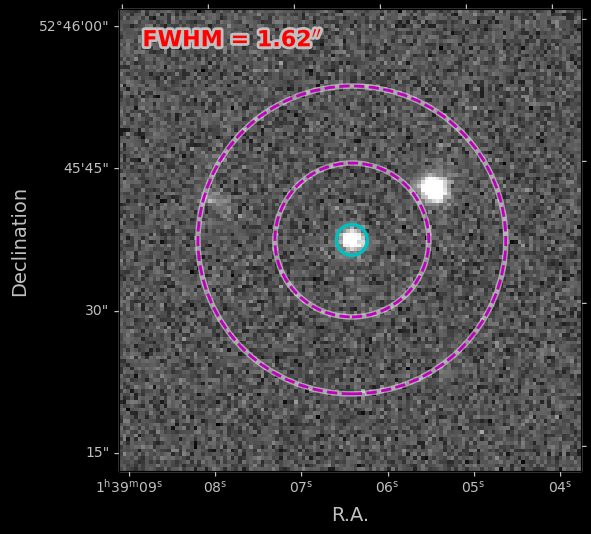


Performing Aperture Photometry...

Finished! 



|    |     mjd |        bjd | date       | time         | filter   |   texp |     mag |    magerr |      Zp |      Zp_err |      cterm |   cterm_err |   Nfit |      sn |   fwhm |   aper_rad (pix) |   airmass | site_id   | telescope   |   temp |   humidity |   wind |   sky |   moonfrac |   moondist |   moonalt |
|---:|--------:|-----------:|:-----------|:-------------|:---------|-------:|--------:|----------:|--------:|------------:|-----------:|------------:|-------:|--------:|-------:|-----------------:|----------:|:----------|:------------|-------:|-----------:|-------:|------:|-----------:|-----------:|----------:|
|  0 | 59400.4 | 2.4594e+06 | 2021-07-05 | 10:38:18.267 | gp       | 119.98 | 18.4104 | 0.0251076 | 3.01155 | 5.38347e-06 | -0.0829394 |  1.2655e-05 |   1259 | 43.3651 |   1.62 |          4.16452 |    1.2987 | elp       | 1m0-08      |     68 |       64.1 |  7.425 | 21.35 |   0.180544 |    41.8201 |   23.2218 |

In [3]:
# Constraints used for the Pan-STARRS1 queries
constraints = {
    'ng.gt':3, # At least 4 detections in g,r,i
    'nr.gt':3,
    'ni.gt':3,
    'nDetections.gt':11, # At least 12 detections total
    'gMeanPSFMag.gt':14.0, # mag>14 to exclude saturated objects
    'rMeanPSFMag.gt':14.0,
    'iMeanPSFMag.gt':14.0
}

# Where to save outputs
data_dir = "../data/"

# Run photometry pipeline
phot_dat = lco_redux_target(
    image_name,
    target_coord,
    comp_coord=comp_coord,  # If None, uses target coords for FWHM estimate
    source_match_limit=100, # Minimum number of PS1-matched sources required
    
    # Aperture size params, in FWHM units
    r_aperture=1.0,
    r_inner_annulus=5.0,
    r_outer_annulus=10.0,
    
    # DAOStarFinder params
    DAO_fwhm=1.3,       # FWHM scaling factor
    DAO_bkgscale=3.0,   # Background threshold = median_bkg + (DAO_bkgscale * MAD_bkg)
    DAO_sharp_high=0.6, # Sharpness upper limit
    DAO_peaklimit=0.9,  # Linearity limit scaling factor
    
    # "Target query" refers to Pan-STARRS1 query used
    # to get PS1 magnitudes for the target source
    target_query_constraints=constraints,
    target_query_save=False,
    
    # "Full query" refers to a PS1 query that covers
    # the whole image FOV, used to calibrate photometry
    full_query_constraints=constraints,
    full_query_save=True,
    full_query_dir=data_dir, 
    full_query_name="ps_query.csv",
    full_query_format="csv",
    
    # Whether to save photometry results to file
    phot_save=True,
    phot_dir=data_dir,
    phot_name=None, # Default = <image_name>_phot.csv
    
    # Whether to plot/save image cutout
    plot_cutout=True,
    plot_save=True,
    plot_dir=data_dir,
    plot_name=None, # Default = <image_name>_cutout.png
    
    # Whether to print out final results
    verbose=False
)

# Display result
if phot_dat is not None:
    display(Markdown(phot_dat.to_markdown()))